# INFO371 Problem Set 6: Naive Bayes
## 1 Load data
Load data and split it into working and testing chunks. But before you begin: ensure you can save a
dataframe in a format you can load back in afterwards. pd.to_csv is a good bet, but it has a lot of
options which may screw up the way you read data. Ensure you can store data in a way that you can
read it back in correctly, including that missings remain missings.
1. create a tiny toy data frame that includes some numbers, strings, and missings. Save it and ensure
you can reload it in the correct form.
Now you are good to go:
2. load the data (available on canvas: files/data/rotten-tomatoes.csv). DO NOT LOOK AT IT!
3. split the dataset into working-testing parts (80/20 or so). Note that sklearn's train_test_split
can easily handle dataframes. Just for your confirmation, ensure that the size of the working and
testing data look reasonable.
4. now save the test data and delete it from memory. Use python's del statement, or R-s rm function.


In [3]:
#load libraries 
import matplotlib 
print("Maplotlib version:    %6.6s" % matplotlib.__version__)
%matplotlib inline
# needed for inline plots in notebooks
import matplotlib.pyplot as plt  
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

Maplotlib version:     2.2.3


In [4]:
#create a tiny toy dataframe?
tiny = pd.DataFrame(np.random.randn(5, 3), index=['a', 'c', 'e', 'f', 'h'], 
                  columns=['one', 'two', 'three'])
tiny['four'] = 'bar'
tiny['five'] = tiny['one'] > 0
tiny = tiny.reindex(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])

#save file
tiny.to_csv('tiny.csv', sep='\t', encoding='utf-8', index = False)

In [5]:
reload_tiny = pd.read_csv('tiny.csv', sep = '\t')
reload_tiny

,one,two,three,four,five
0,0.302547,0.153268,-1.138920,bar,True
1,NaN,NaN,NaN,NaN,NaN
2,-1.050233,-2.062735,-0.888332,bar,False
3,NaN,NaN,NaN,NaN,NaN
4,0.299053,-0.400327,0.132046,bar,True
5,0.421729,0.729466,0.364479,bar,True
6,NaN,NaN,NaN,NaN,NaN
7,-0.905065,-1.953972,-0.209700,bar,False


In [6]:
tomatoes = pd.read_csv("rotten-tomatoes.csv.gz")
tomatoes.isna().sum()

critic         705
fresh            0
imdb             0
link             0
publication      0
quote            0
review_date      0
rtid             0
title            0
dtype: int64

In [7]:
#load data
tomatoes = pd.read_csv("rotten-tomatoes.csv.gz")

tomatoes = tomatoes.dropna(subset=['fresh'])
tomatoes = tomatoes.loc[tomatoes.fresh != 'none']

train,test = train_test_split(
    tomatoes, test_size = 0.2, random_state = 11)

test.to_csv('test_data.csv', sep='\t', encoding='utf-8', index = False)

PermissionError: [Errno 13] Permission denied: 'test_data.csv'

In [8]:
del test

In [9]:
tomatoes.fresh.unique()

array(['fresh', 'rotten'], dtype=object)

## 2 Explore and clean the data
Now when the test data is put aside, we can breath out and take a closer look how does the work data
look like.
1. Take a look at a few lines of data (you may use pd.sample for this).
2. print out all variable names.
3. create a summary table (maybe more like a bullet list) where you print out the most important
summary statistics for the most interesting variables. The most interesting facts you should present
should include: a) number of missings for fresh and quote; b) all different values for fresh/rotten
evaluations; c) counts or percentages of these values; d) number of zero-length or only whitespace
quote-s; e) minimum-maximum-average length of quotes (either in words, or in characters). (Can
you do this as an one-liner?); f) how many reviews are in data multiple times. Feel free to add more
figures you consider relevant.
4. Now when you have an overview what you have in data, clean it by removing all the inconsistencies
the table reveals. We have to ensure that the central variables: quote and fresh are not missing, and
quote is not an empty string (or just contain spaces and such).
I strongly recommend to do it as a standalone function because at the end you have to perform
exactly the same cleaning operations with your test data too.


In [10]:
print(train.sample(5))
print(list(train))

                  critic   fresh    imdb  \
4188  Jonathan Rosenbaum  rotten  116908   
3778          A.O. Scott  rotten  430770   
4927      Desson Thomson   fresh   93191   
4166          Hal Hinson  rotten   95016   
3282      Stephen Holden   fresh  134618   

                                                   link      publication  \
4188  http://www.chicagoreader.com/chicago/the-long-...   Chicago Reader   
3778  http://movies.nytimes.com/2008/09/12/movies/12...   New York Times   
4927  http://www.washingtonpost.com/wp-srv/style/lon...  Washington Post   
4166  http://www.washingtonpost.com/wp-srv/style/lon...  Washington Post   
3282  http://movies.nytimes.com/movie/review?res=9A0...   New York Times   

                                                  quote          review_date  \
4188  Frankly, if I had to see either Harlin-Davis m...  2011-10-25 00:00:00   
3778  It hurts especially to watch Ms. Bening and Ca...  2008-09-12 00:00:00   
4927  a soaring vision that appeals to

In [11]:
#summary table for tomatoe train
print(train.isnull().sum())
print(train['fresh'].unique())

print('(fresh = fresh): ' + str((train.fresh == 'fresh').sum()))
print('(fresh = rotten): ' + str((train.fresh == 'rotten').sum()))
print('(fresh = none): ' + str((train.fresh == 'none').sum()))


#quotes
quotes = train.quote.unique()
emptyquotes = 0
for quote in quotes: 
    if quote.isspace(): 
        emptyquotes += 1
print("quotes with whitespace: " + str(emptyquotes))

print('number of rows with dumplicate reviews: ' + str(train.duplicated().sum()))

critic         558
fresh            0
imdb             0
link             0
publication      0
quote            0
review_date      0
rtid             0
title            0
dtype: int64
['rotten' 'fresh']
(fresh = fresh): 6709
(fresh = rotten): 4026
(fresh = none): 0
quotes with whitespace: 0
number of rows with dumplicate reviews: 379


## 3 Naïve Bayes
Now where you are familiar with the data, it's time to get serious and implement the Naive Bayes classifier
from scratch. But first things first.
1. Ensure you are familiar with Naive Bayes. Consult the readings, available on canvas. Schutt &
O'Neill is an easy and accessible (and long) introduction, Whitten & Frank is a lot shorter but still
accessible introduction.
2. Convert your data (quotes) into bag-of-words. Your code should look something along the lines as
in PS4:

However, now we don't want BOW that contains counts of words in quotes, but just 1/0 (or true/-
false) for the presence/non-presence of the words. Convert the count-based BOW into such a presence
BOW. Hint: think in terms of vectorized (universal) functions.
3. Split your work data and target (i.e. the variable fresh) into training and validation chunks (80/20
or so). Later we also do cross-validation, but for now, a simple training/validation will do.
Good. Now you are ready with the preparatory work and it's time to dive into the real thing. Let's
implement Naive Bayes. Use only training data in the fitting below.
*remember there are more directions*



7. Print the resulting confusion matrix and accuracy (feel free to use existing libraries).


In [12]:
# convert data to bag of words
vectorizer = CountVectorizer()
# define vecotrizer
X = vectorizer.fit_transform(train.quote.values)
# vectorize your data. Note: this creates a sparce matrix,
# use .toarray() if you want a dense matrix.
words = vectorizer.get_feature_names()
# in case you want to see what are the actual words
#replace counts above 1 with binary value 1
X[X > 1] = 1
#split data and target into training and validation parts
X_train, X_test, y_train, y_test = train_test_split(
    X, train['fresh'], test_size = 0.2, random_state = 11)

In [13]:
#priori probability of being fresh or rotten
f = len(y_train[y_train == 'fresh'])/len(y_train)
r = len(y_train[y_train == 'rotten'])/len(y_train)

In [14]:
#compile X_train into a dataframe
X_train = X_train.toarray()
X_train_df = pd.DataFrame(data = X_train, columns = words)
X_train_df['_val'] = y_train

In [15]:
#calculating the total instances each words shows up in rotten quotes
rottentotal = X_train_df.loc[X_train_df['_val'] == 'rotten']
rottentotal = rottentotal.sum(axis = 0)
rottentotal = rottentotal[:-1]

In [16]:
#calculating total instances each word shows up in fresh quotes
freshtotal = X_train_df.loc[X_train_df['_val'] == 'fresh']
freshtotal = freshtotal.sum(axis = 0)
freshtotal = freshtotal[:-1]

In [17]:
rottenprob = rottentotal/sum(rottentotal)
freshprob = freshtotal/sum(freshtotal)

In [18]:
table = pd.DataFrame()
table['fresh_counts'] = freshtotal
table['rotten_counts'] = rottentotal
table['fresh_prob'] = freshprob
table['rotten_prob'] = rottenprob
table = table.reset_index()
table.columns = ['word', 'f_counts', 'r_counts', 'f_prob', 'r_prob']

In [19]:
X_test = X_test.toarray()

In [20]:
#function finds fresh and rotten probabilities associated with one BOW quote
#stores both fresh probabilities and rotten probabilities into two lists
def findProb(quote, table):
    fresh_probability = []
    rotten_probability = []
    for i in range(len(quote)): 
        if quote[i] == 1:
                fresh_probability.append(table.f_prob[i])
                rotten_probability.append(table.r_prob[i])
    return fresh_probability, rotten_probability    

In [21]:
predictions = {'fp': [], 'rp': []}
for row in X_test:
    fp, rp = findProb(row, table)
    freshp = 0
    rottenp = 0
    freshp = np.prod(fp) * f
    rottenp = np.prod(rp) * r
    predictions['fp'].append(freshp)
    predictions['rp'].append(rottenp)

In [22]:
probabilities_df = pd.DataFrame(data = predictions)

In [24]:
y_test.head()

6396     rotten
5717      fresh
6747     rotten
12911     fresh
11323     fresh
Name: fresh, dtype: object

In [25]:
probabilities_df['indices'] = y_test.index.values

In [28]:
probabilities_df['pred'] = probabilities_df['fp'] > probabilities_df['rp']

In [29]:
probabilities_df['pred'] = probabilities_df['pred'].replace([True, False], ['fresh', 'rotten'])
probabilities_df.sample(10)

,fp,rp,indices,pred
1813,0.000000e+00,0.000000e+00,357,rotten
1710,2.921434e-38,0.000000e+00,11332,fresh
268,0.000000e+00,0.000000e+00,7343,rotten
326,0.000000e+00,0.000000e+00,12928,rotten
559,0.000000e+00,0.000000e+00,13389,rotten
1910,0.000000e+00,0.000000e+00,4314,rotten
1979,7.623648e-78,1.226950e-77,3698,rotten
396,0.000000e+00,0.000000e+00,2071,rotten
67,5.335669e-79,0.000000e+00,3807,fresh
1475,1.069225e-87,0.000000e+00,8247,fresh


In [30]:
accuracy_score(y_test, probabilities_df.pred)

0.4648346530041919

In [31]:
#creating confusion matrix
confusion_matrix(y_test, probabilities_df.pred)

array([[372, 960],
       [189, 626]], dtype=int64)

## 4 Interpretation
Now it is time to look at your fitted model a little bit closer. NB model probabilities are rather easy to
understand and interpret. The task here is to find the best words to predict a fresh, and a rotten review.
And we only want to look at words that are reasonably frequent, say more frequent than 30 times in the
data.

2. Find 10 best words to predict F and 10 best words to predict R. Hint: imagine we have a review that
contains just a single word. Which word will give the highest weight to the probability the review is
fresh? Which one to the likelihood it is rotten?
Comment your results.
3. Print out a few missclassified quotes. Can you understand why these are misclassified?

In [32]:
nltk_stop = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", 
                  "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", 
                  "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs",
                  "themselves", "what", "which", "who", "whom", "this", "that", "these", "those",
                  "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had",
                  "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", 
                  "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against",
                  "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", 
                  "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
                  "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other",
                  "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can",
                  "will", "just", "don", "should", "now"]

In [33]:
for i in range(len(table)):
    if table.word[i] in nltk_stop:
        table = table.drop(i)

In [69]:
#sort table
table_f = table.sort_values(by = 'f_prob', ascending = False).head(20)

table_r = table.sort_values(by = 'r_prob', ascending = False).head(20)

In [70]:
table_f

,word,f_counts,r_counts,f_prob,r_prob
6327,film,549,318,0.00845188,0.00916664
10994,movie,465,282,0.00715869,0.00812891
11621,one,287,170,0.00441838,0.00490041
9768,like,184,106,0.00283269,0.00305555
7255,good,160,92,0.00246321,0.00265198
16143,story,156,84,0.00240163,0.00242138
5750,even,143,54,0.00220149,0.0015566
17141,time,133,77,0.00204754,0.0022196
3286,comedy,130,79,0.00200135,0.00227725
11014,much,128,83,0.00197056,0.00239255


In [71]:
table_r

,word,f_counts,r_counts,f_prob,r_prob
6327,film,549,318,0.00845188,0.00916664
10994,movie,465,282,0.00715869,0.00812891
11621,one,287,170,0.00441838,0.00490041
9768,like,184,106,0.00283269,0.00305555
7255,good,160,92,0.00246321,0.00265198
16143,story,156,84,0.00240163,0.00242138
11014,much,128,83,0.00197056,0.00239255
3286,comedy,130,79,0.00200135,0.00227725
17141,time,133,77,0.00204754,0.0022196
4704,director,126,66,0.00193977,0.00190251


In [37]:
misi = probabilities_df.loc[(probabilities_df.pred != y_test.reset_index(drop = True))].head(5)

In [41]:
misi

,fp,rp,indices,pred
4,0.0,0.0,11323,rotten
5,0.0,0.0,1314,rotten
6,0.0,0.0,9074,rotten
8,0.0,0.0,2479,rotten
11,0.0,0.0,9183,rotten


In [39]:
#access first 5 quotes in validation classifiers. they all ended up being misclassified anyway
misclas = train.loc[misi.indices, :].quote

In [40]:
for quote in misclas:
    print(quote)

The funniest, most knowing and, at heart, sweetest movie about making movies since Tim Burton's larky classic, Ed Wood.
This movie gets its charge not from action pyrotechnics but from its electric barrage of language, wisecracks and dialogue, from the mordant '70s classicism of its long-take camera style and its smart, offbeat, strangely sexy cast.
Cusack and Skye's relationship develops nicely and believably, but Crowe has not written an entirely convincing character for the latter to play.
The mystery of Fischer's talent and torment adds depth to Searching for Bobby Fischer, about a young New York chess prodigy who doesn't want his genius to ruin his life.
To watch the film -- directed with eye-opening vigor by Shekhar Kapur -- is to vicariously experience the social horrors of India's patriarchal system.


In [75]:
print(list(table_r.word))

['film', 'movie', 'one', 'like', 'good', 'story', 'much', 'comedy', 'time', 'director', 'best', 'even', 'little', 'funny', 'may', 'something', 'made', 'picture', 'movies', 'first']


In [76]:
print(list(table_f.word))

['film', 'movie', 'one', 'like', 'good', 'story', 'even', 'time', 'comedy', 'much', 'director', 'best', 'characters', 'well', 'picture', 'action', 'first', 'may', 'made', 'funny']


*interpretation*

It's difficult to tell which words would "best" predict a fresh or rotten model. As can see above, even with common english stop words removed, fresh and rotten words both have common 'movie' terms such as 'film'and 'movie'. However, we can see that the word 'much' is a better 'fresh' word than it is a 'rotten' word and the word 'even' is a better rotten word than it is a fresh word, even though both words are very common in both fresh and rotten.

The quotes listed above are all rotten predicted but actually fresh. I think these quotes were easily misclassified because they contained a lot of movie terms, and these quotes criticized the movie, actors and directing more which would mean using common movie words


## 5 NB with smoothing
So, now you have your brand-new NB algorithm up and running. As a next step, we add smoothing to
it. As you will be doing cross-validation below, your first task is to mold what you did above into two
funcions: one for fitting and another one for predicting.
1. Create two functions: one for fitting NB model, and another to predict outcome based on the fitted
model.
As mentioned above, the model is fully described with 4 probabilities, so your fitting function may
return such a list as the model; and the prediction function may take it as an input.
2. Add smoothing to the model. See Schutt p 103 and 109. Smoothing amounts to assuming that we
have seen every possible work α > 0 times already, for both classes. (If you wish, you can also
assume you have seen the words α times for F and β times for R). Note that α does not have to be
an integer, and typically the best α < 1.
3. Now fit a few models with different α-s and see if the accuracy improves compared to the baseline
case above.


In [42]:
#function for fitting
#parameters: X: prepared bag of words, y - classification, words- words in bag of words
#returns dataframe of probabilities for each word in rotten/fresh text, and the priori probabilties for
#fresh and rotten 
def fit(X, y, words,alpha):
    #creates table that will be returned
    result = {'f_count': [],'r_count': [], 'f_prob': [], 'r_prob' : []}
    #computes priori probability 
    fpriori = len(y[y == 'fresh'])/len(y)
    rpriori = len(y[y == 'rotten'])/len(y)
    #organize BOW and classification into dataframe
    X_df = pd.DataFrame(data = X, columns = words)
    X_df['_val'] = y
    #create calculate counts for fresh/rotten each word
    rsum = X_df.loc[X_df['_val'] == 'rotten'].sum(axis = 0)[:-1]
    fsum = X_df.loc[X_df['_val'] == 'fresh'].sum(axis = 0)[:-1]
    result['r_count'] = rsum
    result['f_count'] = fsum
    result['r_prob'] = smoothprob(alpha, rsum)
    result['f_prob'] = smoothprob(alpha, fsum) 
    #convert to dataframe
    result = pd.DataFrame(data = result)
    result = result.reset_index()
    result.columns = ['words', 'f_count', 'r_count', 'f_prob', 'r_prob']
    return result, fpriori, rpriori
    
#function for predicting
def predict(table, f, r, Xt):
    predictions = {'fp': [], 'rp': []}
    for row in Xt:
        fp, rp = findProb(row, table)
        freshp = 0
        rottenp = 0
        freshp = np.prod(fp) * f
        rottenp = np.prod(rp) * r
        predictions['fp'].append(freshp)
        predictions['rp'].append(rottenp)
    predictions = pd.DataFrame(data = predictions)
    predictions['pred'] = predictions['fp'] > predictions['rp']
    predictions['pred'] = predictions['pred'].replace([True, False], ['fresh', 'rotten'])
    return predictions

In [43]:
#function made for smoothing
def smoothprob(alpha, sums):
    newsums =  [(x + alpha) for x in sums]
    newsums = [x/(alpha * len(sums) + sum(sums)) for x in newsums]
    return newsums

In [168]:
#add smoothing alpha = 1
nb_fit, f, r = fit(X_train, y_train, words, 0.1)

In [169]:
nb_fit.head()

,words,f_count,r_count,f_prob,r_prob
0,000,3,0,0.000046,0.000003
1,0014,0,0,0.000001,0.000003
2,007,3,2,0.000046,0.000057
3,044,0,1,0.000001,0.000030
4,07,0,0,0.000001,0.000003


In [170]:
predict1 = predict(nb_fit, f, r, X_test)

In [171]:
predict1.sample(10)

,fp,rp,pred
1171,7.142673e-11,3.576093e-09,rotten
126,3.183950e-69,2.547799e-68,rotten
163,8.676050e-40,7.042108e-39,rotten
590,1.279738e-40,1.813403e-39,rotten
1051,4.279123e-132,1.186490e-133,fresh
1404,7.204958e-61,1.459291e-62,fresh
395,9.466908e-41,6.713255e-41,fresh
1820,5.150933e-78,1.018562e-75,rotten
580,8.388483e-80,2.901441e-79,rotten
1007,2.889668e-56,8.316961e-56,rotten


In [172]:
confusion_matrix(y_test, predict1.pred)

array([[858, 474],
       [540, 275]], dtype=int64)

In [173]:
accuracy_score(y_test, predict1.pred)

0.527713088029809

In [174]:
nb_fit, f, r = fit(X_train, y_train, words, 0.5)

In [175]:
nb_fit.sample(10)

,words,f_count,r_count,f_prob,r_prob
1144,astringency,0,1,0.000007,0.000034
16398,suddenly,2,1,0.000034,0.000034
16608,sweepstakes,0,0,0.000007,0.000011
6034,factor,5,0,0.000074,0.000011
11234,negligent,0,1,0.000007,0.000034
9883,locomotive,1,1,0.000020,0.000034
7431,grisham,5,0,0.000074,0.000011
5276,eco,0,0,0.000007,0.000011
12630,poor,7,3,0.000101,0.000079
8302,ideologically,1,0,0.000020,0.000011


In [176]:
predict2 = predict(nb_fit, f, r, X_test)

In [177]:
confusion_matrix(y_test, predict2.pred)

array([[954, 378],
       [610, 205]], dtype=int64)

In [178]:
accuracy_score(y_test, predict2.pred)

0.5398230088495575

In [179]:
nb_fit, f, r = fit(X_train, y_train, words, 0.75)
predict3 = predict( nb_fit, f, r, X_test)
print(confusion_matrix(y_test, predict3.pred))
print(accuracy_score(y_test, predict3.pred))

[[1046  286]
 [ 648  167]]
0.5649743828598044


In [180]:
nb_fit, f, r = fit(X_train, y_train, words, 0.99)
predict4 = predict( nb_fit, f, r, X_test)
print(confusion_matrix(y_test, predict4.pred))
print(accuracy_score(y_test, predict4.pred))

[[1134  198]
 [ 698  117]]
0.5826734979040522


In [181]:
nb_fit, f, r = fit(X_train, y_train, words, 2)
predict5 = predict( nb_fit, f, r, X_test)
print(confusion_matrix(y_test, predict5.pred))
print(accuracy_score(y_test, predict5.pred))

[[1291   41]
 [ 773   42]]
0.6208663251047974


## 6 Cross-Validation
Finally (well, almost finally), we do cross-validation. This is another piece of code you have to implement
yourself, not use existing libraries.

* Implement k-fold CV. I recommend to implement it as a function that a) puts your data into
random order; b) splits these into k chunks; c) selects a chunk for testing and the others for training;d) trains your NB model on the training chunks; e) computes accuracy on training chunk; f) returns mean accuracy over all these k trials. The function should also take α as an argument, this is the hyperparameter you are going to optimize.

* Find the optimal α by 5-fold CV using your own CV code. You have to find the cross-validated
accuracies for a number of α-s between 0 and 1. Present the accuracy as a function of α on a plot
and indicate which one is the best α.

In [147]:
#k-fold cv function
def crossval(alpha, data, words, K):
    #makes copy of data and splits into K chunks
    data_copy = data.sample(frac=1).reset_index(drop = True)
    n = int(len(data_copy)/K)
    list_chunks = [data_copy[i:i+n] for i in range(0,data_copy.shape[0],n)]
    accuracies = []
    for i in range(K):
        test_ch = list_chunks.pop(i)
        tX = test_ch.drop('_val', axis = 1)
        tX = tX.as_matrix()
        ty = test_ch['_val']
        chunk = pd.concat(list_chunks)
        X = chunk.drop(['_val'], axis = 1)
        X = X.as_matrix()
        y = chunk['_val']
        fitted,f,r = fit(X, y, words, alpha)
        predicted = predict(fitted, f, r, tX)
        accuracies.append(accuracy_score(ty, predicted.pred))
        list_chunks.insert(i, test_ch) 
    acc = np.mean(accuracies)
    return acc, accuracies

In [45]:
X = X.toarray()

In [46]:
X_df = pd.DataFrame(data = X, columns = words)
X_df['_val'] = train.fresh.reset_index()['fresh']

In [148]:
#1 out of 5 folds alpha = 0.2
a,b = crossval(0.2, X_df, words, 5)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [151]:
#2 out of 5 folds alpha = 0.4
c,d = crossval(0.4, X_df, words, 5)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [152]:
#3 out of 5 folds alpha = 0.6
e,f = crossval(0.6, X_df, words, 5)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [154]:
#4 out of 5 folds alpha = 0.8
g,h = crossval(0.8, X_df, words, 5)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [157]:
#5 out of 5 folds alpha = 0.0
i, j = crossval(0, X_df, words, 5)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [158]:
print(i,a, c, e, g)

0.5171867722403353 0.6791802515137401 0.6884955752212389 0.6935258500232883 0.6991150442477877


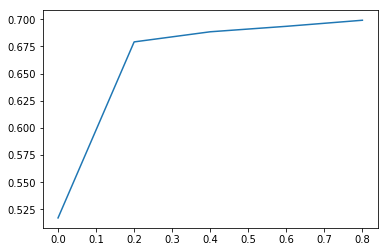

In [160]:
df = pd.DataFrame(data = {'alpha': [0.0, 0.2, 0.4, 0.6, 0.8], 'acc': [i,a,c,e,g]})
plt.plot(df.alpha, df.acc)

0.8 is the best alpha

## 7 Final model performance
Finally (and now I mean finally,), estimate the model performance on the testing data. Complete this
section after everything else is done and you are ready to submit your work. Don't improve model
after you have loaded testing data!
1. Fit your NB model using the cross-validated optimal alpha using your complete work data (both
training and validation). This is your best and final model.
2. Load your testing data. Clean it using exactly the same procedure (you made a function for this,
right?) and transform it into BOW-s.
Note: above I suggested using vectorizer.fit_transform(quote) function to create the BOW.
Here I recommend to use vectorizer.transform(quote). This is because we don't want to change
the vocabulary (that's what the fit-part does), only to transform it into the BOW.
3. Predict the F/R class on testing data. Compute accuracy. Present it.
4. Did you get a better or worse result compared to the k-NN and TF-IDF in PS04?
That is it. This is your final model performance measure. Feel free to compare it with your peers, but
even if abysmal, don't play with the model any more! Just submit, and you are done ,... really
done, this was your last problem set!


In [161]:
#prepare test data
test = pd.read_csv("test_data.csv", sep = '\t')
X_val = vectorizer.transform(test.quote.values).toarray()

In [162]:
#fit model with entire train 
model_fit, f, r = fit(X, train.fresh, words, 0.8)

In [163]:
model_pred = predict(model_fit, f, r, X_val)

In [166]:
confusion_matrix(test.fresh, model_pred.pred)

array([[1326,  354],
       [ 799,  205]], dtype=int64)

In [167]:
accuracy_score(test.fresh, model_pred.pred)

0.5704172876304023

the Naive Bayes was better than my Knn or Tfidf